In [1]:
%run ../Getting_data/Getting_Data.ipynb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54454 entries, 0 to 54453
Data columns (total 49 columns):
Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)    54454 non-null float64
datetime                                                                         54454 non-null datetime64[ns, UTC]
datetime_utc                                                                     54454 non-null datetime64[ns, UTC]
tz_time                                                                          54454 non-null datetime64[ns, UTC]
geo_id                                                                           54454 non-null int64
geo_name                                                                         54454 non-null object
Demanda_programada_P48_total                                                     54454 non-null float64
Precio_mercado_SPOT_Diario                                                       54454 non-null float64
Precio_mercado_SPOT_Intrad

In [30]:
import datetime as dt
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50, 15]
from pandas_profiling import ProfileReport

In [15]:
def plot_year_x(year,df,column):
    """
    With this function we will plot the time series of the year that we indicate.
    """
    # We create the dataframe to plot
    plot=df[df['datetime'].dt.year==year][[column,'datetime']]
    # We plot the dataframe
    sns.lineplot(x='datetime',y=column,data=plot)

def plot_all_years(df,column,resampling='D'):
    """
    With this function we will plot all the years, resampled by the period we indicate. The values shown will be the 
    mean of the period
    """
    # We create the dataframe to plot
    df_aux=df.set_index('datetime')[column].resample(resampling).mean()
    # We plot the dataframe
    sns.lineplot(x=df_aux.index,y=df_aux)  

In [16]:
df = pd.read_csv('TFM_dataframe.csv',parse_dates=['datetime','datetime_utc','tz_time'])

### Time series index

In [17]:
df = df.set_index('datetime')

### Calculations based on other columns

It may be useful the use of the weekday

In [18]:
df['Weekday']=df.index.strftime('%A')
df['Hour']=df.index.hour

### Fill NaN values

In [19]:
df[['Red_Electrica','IBEX35']]=df[['Red_Electrica','IBEX35']].ffill()

In [20]:
df.drop(['day','month','year','hour','quarter','Consumer_price_index', 'Time_required_to_get_electricity_(days)',
       'Inflation,consumer_prices_(annual_%)','Employment_in_industry_(%_of_total_employment)','geo_id','geo_name',
       'PIB_Trimestral', 'Var_Trim_PIB_(%)', 'Var_anual_PIB_Trim_(%)','datetime_utc','tz_time'],axis=1,inplace=True)

We may interpolate for those values missing for the market spot price:

In [21]:
df['Precio_mercado_SPOT_Intradiario_Sesion_1']=df['Precio_mercado_SPOT_Intradiario_Sesion_1'].interpolate(method='linear', limit_area='inside')
df['Precio_mercado_SPOT_Intradiario_Sesion_2']=df['Precio_mercado_SPOT_Intradiario_Sesion_2'].interpolate(method='linear', limit_area='inside')

We may consider that if the programmed generation of power is null it may be because it is considered 0:

In [22]:
df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]]=df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]].fillna(0)

### Statistics

In [25]:
df.describe()

,Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA),Demanda_programada_P48_total,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Generacion_programada_P48_Biogas,Generacion_programada_P48_Biomasa,Generacion_programada_P48_Ciclo_combinado,...,Generacion_programada_P48_Residuos_domesticos_y_similares,Generacion_programada_P48_Residuos_varios,Generacion_programada_P48_Solar_fotovoltaica,Generacion_programada_P48_Solar_termica,Generacion_programada_P48_Subproductos_mineria,Generacion_programada_P48_Turbinacion_bombeo,holidays,Red_Electrica,IBEX35,Hour
count,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,...,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000,54454.000000
mean,92.264796,28274.804681,47.645704,47.341215,47.317518,-19.243090,-46.390311,64.896705,393.865351,3551.653085,...,119.383593,102.719984,964.137990,602.004409,25.518472,249.563106,0.022037,13.952407,9664.200751,11.499596
std,39.056999,4675.215643,14.887291,14.994888,15.019109,464.274961,234.634058,40.782189,108.387248,2443.451037,...,71.642494,71.819706,1257.090522,710.503320,21.295173,389.209949,0.146805,3.839828,1012.025109,6.922056
min,10.000000,16428.400000,0.030000,0.000000,0.000000,-3800.000000,-2600.000000,0.000000,141.200000,307.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.931983,6107.200195,0.000000
25%,60.990000,24366.325000,39.420000,39.040000,39.100000,-300.000000,-100.000000,11.100000,323.800000,1838.000000,...,73.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,10.397486,9059.291016,5.250000
50%,78.820000,28421.000000,48.820000,48.490000,48.340000,0.000000,0.000000,87.300000,356.200000,2745.450000,...,157.300000,129.200000,80.600000,284.300000,41.000000,60.100000,0.000000,15.537788,9661.799805,11.000000
75%,131.030000,31849.450000,58.087500,57.820000,57.620000,200.000000,0.000000,93.200000,490.800000,4471.225000,...,182.600000,160.175000,1951.700000,989.325000,45.200000,341.000000,0.000000,17.097551,10394.189453,17.000000
max,221.370000,41297.900000,101.990000,102.490000,103.610000,3930.000000,1800.000000,150.200000,661.400000,16938.700000,...,205.000000,232.800000,6699.300000,2221.800000,46.400000,2831.300000,1.000000,19.610001,11866.388672,23.000000


In [31]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

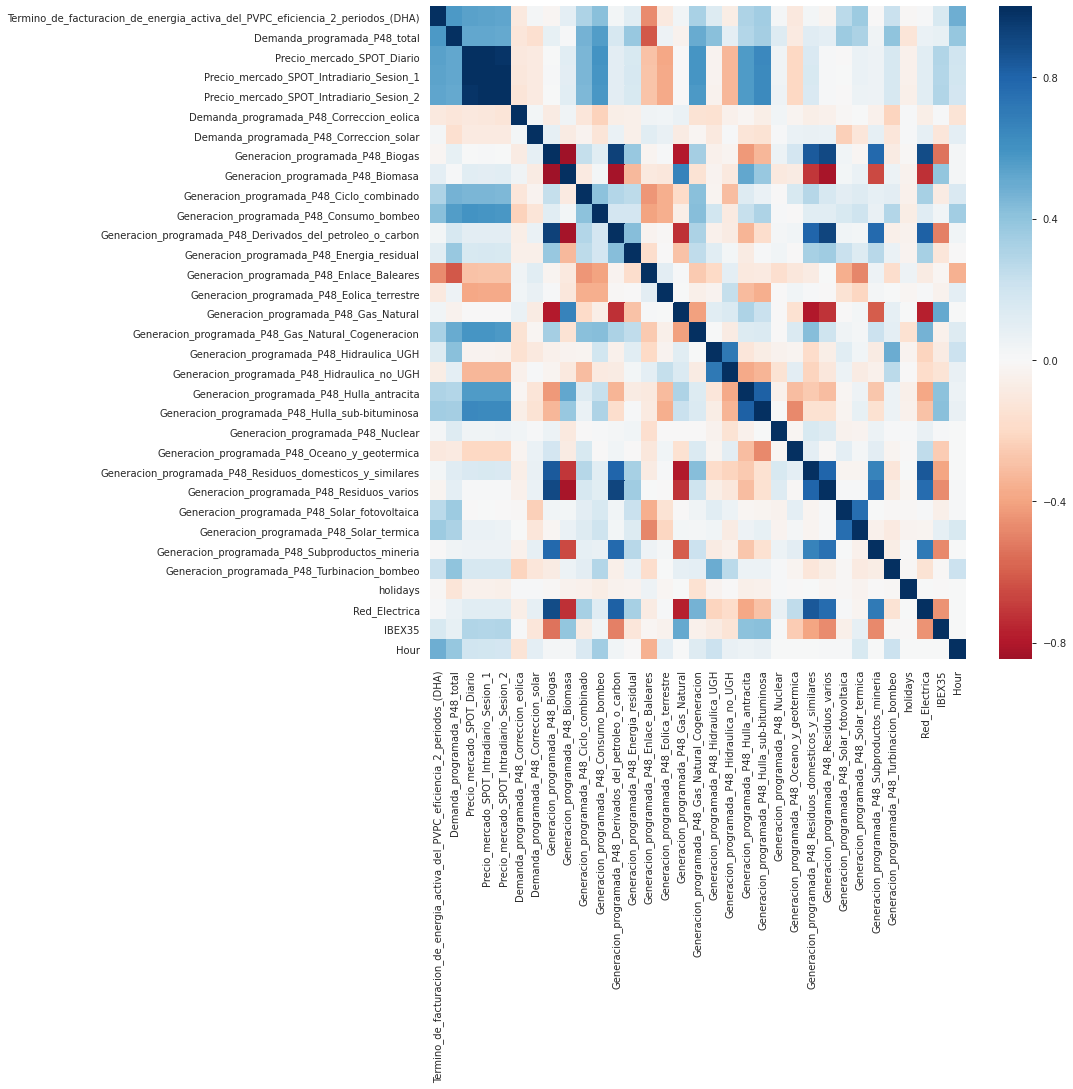

In [47]:
plt.rcParams['figure.figsize'] = [12, 12]
sns.heatmap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0)

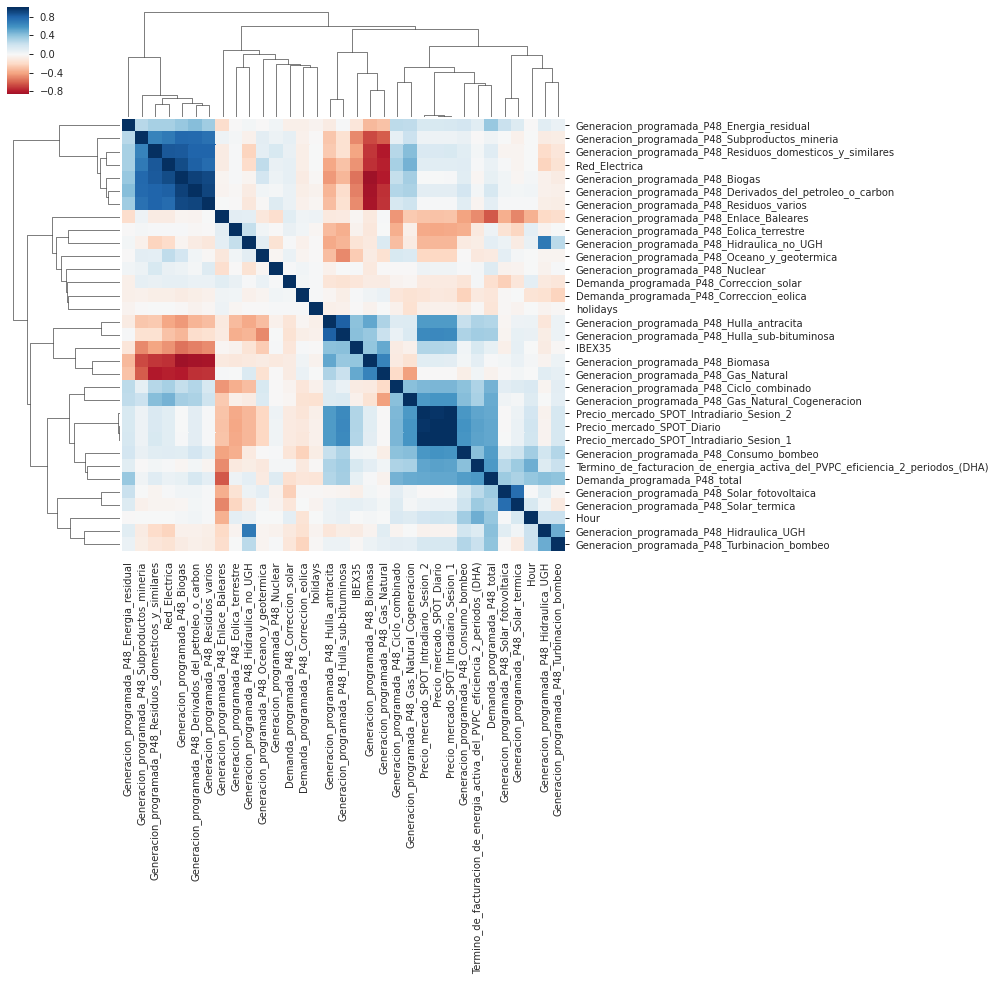

In [48]:
sns.clustermap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0)

In [24]:
df.to_csv('../Models/final_dataframe.csv')